In [1]:
import torch
from torch import ones, zeros, tensor, eye

from torch.distributions import Categorical

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='white', palette='colorblind', color_codes=True, font_scale=1.5)

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/control_dilemmas')])

from befit.simulate import Simulator
from befit.tasks import bandits
from befit.agents import AIBandits, Random

from setup_environment import *

context = torch.from_numpy(np.load('context_{}.npy'.format(blocks)))
offers = torch.from_numpy(np.load('offers_{}.npy'.format(blocks)))

tensor(5.1435)
tensor(5.0000)


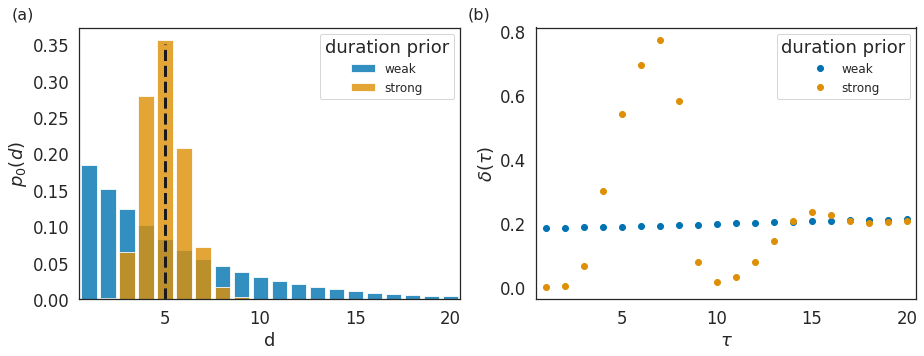

In [2]:
nd = 20
alpha = [1., 20.]
beta = [.2, 4.]
d = torch.arange(1., nd+1.)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
label = ['weak', 'strong']
probs = []
for i in range(2):
    probs.append((-d*beta[i] + (alpha[i] - 1)*d.log() ).softmax(-1))
    print((d*probs[-1]).sum())
    axes[0].bar(d, probs[-1], label=label[i], alpha=.8);
    
axes[0].vlines(5, .0, .35, lw=3, linestyle='--')
axes[0].set_xlim([.5, 20.5])
axes[0].legend(title='duration prior', fontsize=12)
axes[0].set_xlabel('d');
axes[0].set_ylabel(r'$p_0(d)$');

#### compute effective change probability ####

Bdd = zeros(nd, nd)
Bdd[range(1, nd), range(nd-1)] = 1.

nc=6
Bccd = zeros(nd, nc, nc)
Bccd[0] = (ones(nc, nc) - eye(nc))/(nc-1)
Bccd[1:] = eye(nc).repeat(nd-1, 1, 1)

for i in range(len(alpha)):
    Bdd[0] = ( -d*beta[i] + (alpha[i] - 1)*d.log() ).softmax(-1)
    
    delta = []
    tm = torch.einsum('ij,ikl->ikjl', Bdd, Bccd)
    joint = torch.einsum('ijkl,i->jkl', tm, Bdd[0])[0]
    for tau in range(1, nd+1):
        if tau == 1:
            delta.append(1 - joint.sum(-2)[0])
        else:
            marg = joint.sum(-2)
            cond = marg/marg.sum(-1, keepdim=True)
            delta.append(1 - cond[0, 0])
            joint = joint.sum(0)
        
        joint = torch.einsum('ij,ijkl -> jkl', joint, tm)
    
    axes[1].plot(d, torch.stack(delta), 'o', label=label[i]);
    
axes[1].set_ylabel(r'$\delta(\tau)$');
axes[1].set_xlabel(r'$\tau$');
axes[1].legend(title='duration prior', fontsize=12)

axes[0].text(-.15, 1.05, r'(a)', fontsize=16, horizontalalignment='center', 
             verticalalignment='center', transform=axes[0].transAxes)
axes[1].text(-.15, 1.05, r'(b)', fontsize=16, horizontalalignment='center', 
             verticalalignment='center', transform=axes[1].transAxes)

fig.savefig('Fig11.png', bbox_inches='tight', transparent=True, dpi=300)

In [ ]:
a = 2*torch.stack([torch.eye(nf), torch.eye(nf)]).reshape(-1, 3)[arm_types] + 1
a = a.repeat(nsub, 1, 1, 1)

nd = 20
pars = {
    'nd': nd, # number of duration states
    'ns': 4,  # number of options
    'na': na, # number of actions
    'nc': 6,  # number of contexts
    'nf': nf, # number of features
    'ni': 2, # number of internal states
}

Bdd = zeros(nd, nd)

d = torch.arange(1., nd+1.)

alpha = [1., 20.]
beta = [.2, 4.]
Bdd[range(1, nd), range(nd-1)] = 1.

Bccd = zeros(nd, 6, 6)
Bccd[0] = (ones(6, 6) - eye(6))/5
Bccd[1:] = eye(6).repeat(nd-1, 1, 1)

agents = []
envs = []
for i in range(len(alpha)):
    Bdd[0] = ( -d * beta[i] + (alpha[i] - 1) * d.log() ).softmax(-1)
    tm_higher = {
        'context': Bccd,
        'duration': Bdd.clone()
    }

    agents.append(AIBandits(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher}))
    agents[-1].set_parameters(x = [a], depth=trials, epistemic=True)

pars = {
    'nd': nd, # number of duration states
    'ns': 4,  # number of options
    'na': na, # number of actions
    'nc': 6,  # number of contexts
    'nf': nf, # number of features
    'ni': 1, # number of internal states
}    

epistemic = [True, False]
for i in range(2):
    Bdd[0] = ( -d*beta[1] + (alpha[1] - 1)*d.log() ).softmax(-1)
    tm_higher = {
        'context': Bccd,
        'duration': Bdd.clone()
    }
    
    agents.append(AIBandits(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher}))
    agents[-1].set_parameters(x = [a], depth=trials, epistemic=epistemic[i])
    
for i in range(len(agents)):
    envs.append(bandits.MultiArmedBandit(priors, 
                                transitions, 
                                context,
                                offers,
                                arm_types,
                                nsub=nsub, 
                                blocks=blocks, 
                                trials=trials))

sim = Simulator(envs, agents, runs=nsub, blocks=blocks, trials=trials)
sim.simulate_experiment()

In [ ]:
successes = []

out = []
for i in range(1, 4):
    out.append(sim.stimuli['pair_{}'.format(i)]['outcomes'])

for out1, out2, out3 in zip(*out):
    successes.append(torch.stack([out1[-1][-1], 
                                  out2[-1][-1], 
                                  out3[-1][-1]],
                                  -1))
    
successes = torch.stack(successes).float()

df = pd.DataFrame({'context': [1, 1, 2, 2, 3, 3], 'variant': ['A', 'B', 'A', 'B', 'A', 'B']})
g = sns.FacetGrid(df, col='context', row='variant', height=5)
for i in range(2):
    g.axes[i, 0].set_ylabel('success rate')
for j in range(3):
    g.axes[-1, j].set_xlabel('relative segment number')

axes = g.axes.flatten()
colors = sns.color_palette(palette='colorblind')[:3]
labels = ['ADP', 'EFE', 'IV']
for c, vc in enumerate([0, 2, 4, 1, 3, 5]):
    loc = offers[:, 0, 0] == vc
    sccs = successes[loc].reshape(-1, 5, nsub, 3).mean(-2)
    K = sccs.shape[0]
    lws = np.arange(3/(2*K), 3, 3/K)
    if c < 3:
        axes[c].hlines(0.73728, 0, 4, 'k', linestyle='--', lw=3)
    else:
        axes[c].hlines(1., 0, 4, 'k', linestyle='--', lw=3)
        
    for i in range(3):
        for j, lw in enumerate(lws):
            if c == 0 and j == len(lws) - 1:
                label = labels[i]
            else:
                label = None
                
            axes[c].plot(sccs[j, ..., i].numpy().T, c=colors[i], lw=lw);
            
import matplotlib as mpl

legend_data = {}
for i in range(3):
    legend_data[labels[i]] = mpl.patches.Patch(color=colors[i], linewidth=1)
g.add_legend(legend_data, title='agent', label_order=labels)

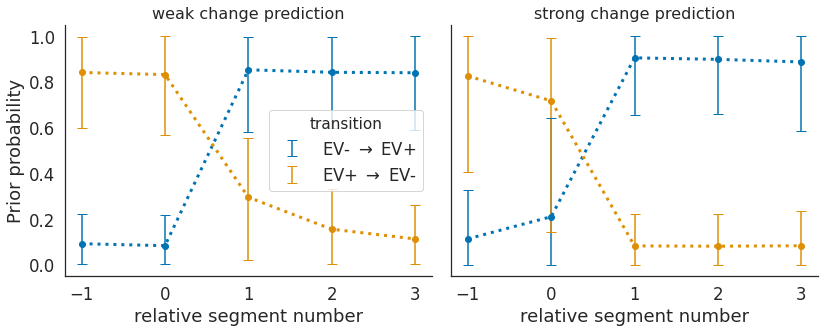

In [5]:
def errorbar(*args, **kwargs):
    x = args[0].values.reshape(-1, 5)[0]
    tmp = args[1].values.reshape(-1, 5)
    mean = tmp.mean(0)
    perc = np.percentile(tmp, [10, 50, 90], 0)
    yerr = [perc[1] - perc[0], perc[2] - perc[1]]
    
    plt.plot(x, mean, 'o', **kwargs)
    kwargs['linestyle'] = ''
    kwargs.pop('lw')
    plt.errorbar(x, perc[1], yerr=yerr, capsize=5, **kwargs)
    

import pandas as pd

cut = 20
offs = offers[:, 0, 0].reshape(-1, 5)[-cut-1:, 0]

offs = offers[:, 0, 0].reshape(-1, 5)[:, 0]
locsA = torch.tensor([1 if offs[j] in [0, 2, 4] else 0 for j in range(len(offs))]).bool()
locsA[:-cut] = False

locsB = torch.tensor([1 if offs[j] in [1, 3, 5] else 0 for j in range(len(offs))]).bool()
locsB[:-cut] = False


rt = torch.arange(-1, 4)

dfs = pd.DataFrame()
name = ['imprecise', 'precise']
for i in range(2):
    internals = torch.stack(agents[i].priors['internals'])
    mi = internals[4:-1].reshape(-1, 5, nsub, 2)


    for n in range(nsub):
        dctA = {
                'relative segment number': rt,
                'Prior probability':mi[locsA[1:], :, n, 0].mean(0),
                'prediction': name[i],
                'subject': n,
                'transition': r'EV- $\rightarrow$ EV+'
        }
        
        dctB = {
                'relative segment number': rt,
                'Prior probability':mi[locsB[1:], :, n, 0].mean(0),
                'prediction': name[i],
                'subject': n,
                'transition': r'EV+ $\rightarrow$ EV-'
        }
        
        dfs = dfs.append(pd.DataFrame(dctA), ignore_index=True)
        dfs = dfs.append(pd.DataFrame(dctB), ignore_index=True)

        
g = sns.FacetGrid(dfs, col='prediction', hue='transition', height=5, aspect=1.18, legend_out=False)

g = g.map(errorbar, 'relative segment number', 'Prior probability', linestyle=':', lw=3).add_legend()

g.axes[0, 0].set_title('imprecise change prediction', fontsize=16)
g.axes[0, 0].set_xticks([-1, 0, 1, 2, 3])
g.axes[0, 1].set_title('precise change prediction', fontsize=16)
g.savefig('Fig8.png', bbox_inches='tight', transparent=True, dpi=300)

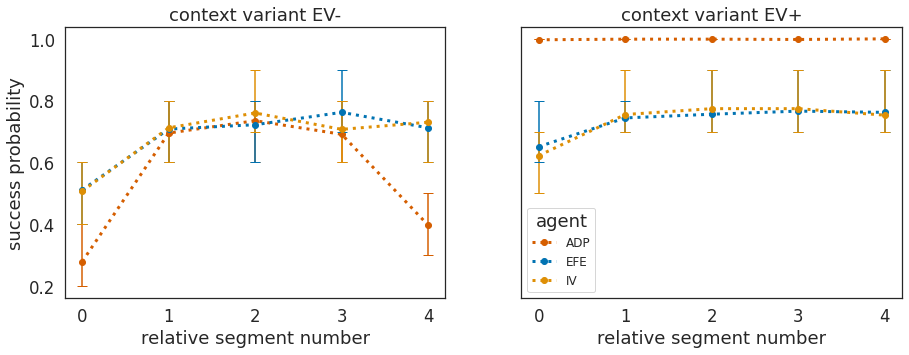

In [6]:
successes = []
out = []

for i in [1, 2, 3]:
    out.append(sim.stimuli['pair_{}'.format(i)]['outcomes'])

for out1, out2, out3 in zip(*out):
    successes.append(torch.stack([out1[-1][-1], 
                                  out2[-1][-1],
                                  out3[-1][-1]],
                                 -1))
    
successes = torch.stack(successes).float()

internals = torch.stack(agents[1].priors['internals'])
good1 = (internals[100::10, :, -2] < .5).sum(-2) > 5

internals = torch.stack(agents[1].priors['internals'])
good2 = (internals[101::10, :, -2] < .5).sum(-2) > 5

cut = 20
res = successes.reshape(-1, 5, nsub, len(agents[1:]))

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

shape = ['o', 'd', 'x']
labels = ['ADP', 'EFE', 'IV']
colors = sns.color_palette(palette='colorblind')[3:4] + sns.color_palette(palette='colorblind')[:2]

x = [0, 1, 2, 3, 4]
    
for i in range(len(agents[1:])):
    mean = res[locsA, ..., i].mean(0).mean(1)
    perc1 = np.percentile(res[locsA, ..., i].mean(0).numpy(), [25, 50, 75], 1)
    yerr1 = [perc1[1] - perc1[0], perc1[2] - perc1[1]]
    axes[0].errorbar(x, perc1[1], yerr=yerr1, c=colors[i], capsize=5, linestyle='');
    axes[0].plot(x, mean.numpy(), 'o:', lw=3, c=colors[i])
    
    mean = res[locsB, ..., i].mean(0).mean(1)
    perc2 = np.percentile(res[locsB, ..., i].mean(0).numpy(), [25, 50, 75], 1)
    yerr2 = [perc2[1] - perc2[0], perc2[2] - perc2[1]]
    axes[1].errorbar(x, perc2[1], yerr=yerr2, c=colors[i], capsize=5, linestyle='')
    axes[1].plot(x, mean, 'o:', lw=3, c=colors[i], label=labels[i])

axes[1].legend(title='agent', fontsize=12);
axes[0].set_ylabel('success probability');
axes[0].set_xlabel('relative segment number');
axes[1].set_xlabel('relative segment number');

axes[0].set_title('context variant EV-')
axes[1].set_title('context variant EV+')

plt.xticks([0, 1, 2, 3, 4]);

fig.savefig('Fig9.png', bbox_inches='tight', transparent=True, dpi=300)

In [19]:
import scipy.stats as stats

m1 = res[locsA].mean(0)

for i in range(5):
    print('adpt-explr', i, stats.wilcoxon((m1[i, :, 0] - m1[i, :, 1]).reshape(-1).numpy()))
    print('adpt-explt', i,stats.wilcoxon((m1[i, :, 0] - m1[i, :, 2]).reshape(-1).numpy()))
    print('explr-explt', i, stats.wilcoxon((m1[i, :, 1] - m1[i, :, 2]).reshape(-1).numpy()))

adpt-explr 0 WilcoxonResult(statistic=1609.0, pvalue=0.8079008784331254)
adpt-explt 0 WilcoxonResult(statistic=284.5, pvalue=7.561782855967422e-13)
explr-explt 0 WilcoxonResult(statistic=252.0, pvalue=2.8405332574727154e-13)
adpt-explr 1 WilcoxonResult(statistic=1289.5, pvalue=0.15314621655667315)
adpt-explt 1 WilcoxonResult(statistic=1666.0, pvalue=0.5931571428673816)
explr-explt 1 WilcoxonResult(statistic=1213.5, pvalue=0.03442763039867409)
adpt-explr 2 WilcoxonResult(statistic=1235.0, pvalue=0.009057762434749437)
adpt-explt 2 WilcoxonResult(statistic=1528.0, pvalue=0.5305718567573704)
explr-explt 2 WilcoxonResult(statistic=1423.0, pvalue=0.07517704747817879)
adpt-explr 3 WilcoxonResult(statistic=1435.5, pvalue=0.11720425918502923)
adpt-explt 3 WilcoxonResult(statistic=1255.5, pvalue=0.11081476929504465)
explr-explt 3 WilcoxonResult(statistic=959.0, pvalue=0.00034509078986780256)
adpt-explr 4 WilcoxonResult(statistic=869.5, pvalue=1.1946602822053395e-06)
adpt-explt 4 WilcoxonResult(s

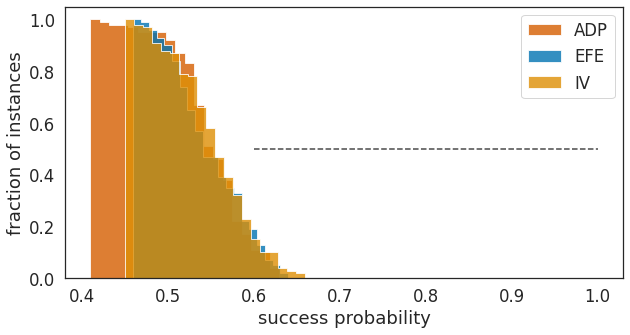

In [8]:
cum_perf = res[-20:].reshape(-1, 100, 4).sum(0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i in [1, 2, 3]:
    plt.hist(cum_perf[:, i].numpy()/100.,
             bins=20,
             color=colors[i - 1],
             density=True,
             cumulative=-1,
             histtype='stepfilled', 
             alpha=.8);

plt.hlines(.5, .6, 1., 'k', linestyle='--', alpha=.8)
#plt.xlim([.6, 1.])
plt.legend(['ADP', 'EFE', 'IV'], loc=1);

plt.ylabel('fraction of instances');
plt.xlabel('success probability');

fig.savefig('Fig10.png', bbox_inches='tight', transparent=True, dpi=300)

In [7]:
print(torch.sum(cum_perf[:, 1] > cum_perf[:, 2].max()), cum_perf[:, 2].max()/100.)

tensor(1) tensor(0.8600)
